In [5]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import csv
import os
import time
cwd = os.getcwd()
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 8)


def settings_load(file_path):
    zeroth_row = True
    with open(file_path , 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter='=')
        output = dict()
        for row in reader:
            output[row[0]] = row[1]
    return output


def csv_load(file_path):
    zeroth_row = True
    with open(file_path , 'rb') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if zeroth_row == True:
                row.remove('')
                row = [float(value) for value in row]
                data = np.array(row)
                zeroth_row = False
            else:
                row.remove('')
                new_row = [float(value) for value in row]
                data = np.vstack([data, new_row])
    return data


def mean_photons_calc(probabilities):
    photons = np.zeros(probabilities.shape[1])
    for i in range(photons.shape[0]):
        for j in range(probabilities.shape[0]):
            photons[i] = photons[i] + j * probabilities[j, i]
    return photons


def times_qload(folder_path):
    times_path = folder_path + '/times'
    times = qload(times_path)
    times = times / (2 * np.pi * 1000)
    return times


def above(x, y, trials):
    difference = y[:, :, np.newaxis] - divider(x, trials)
    above_yn = difference > 0
    return above_yn


class Parameters:
    def __init__(self, wc, wq, eps, g, chi, kappa, gamma, t_levels, c_levels):
        self.wc = wc
        self.wq = wq
        self.eps = eps
        self.g = g
        self.chi = chi
        self.gamma = gamma
        self.kappa = kappa
        self.t_levels = t_levels
        self.c_levels = c_levels

    def copy(self):
        params = Parameters(self.wc, self.wq, self.eps, self.g, self.chi, self.kappa, self.gamma, self.t_levels, self.c_levels)
        return params


class Results:
    def __init__(self, params=np.array([]), wd_points=np.array([]),
                 transmissions=np.array([]), edge_occupations_c=np.array([]), edge_occupations_t=np.array([])):
        self.params = params
        self.wd_points = wd_points
        self.transmissions = transmissions
        self.edge_occupations_c = edge_occupations_c
        self.edge_occupations_t = edge_occupations_t
        self.abs_transmissions = np.absolute(self.transmissions)
        self.size = self.wd_points.size

    def concatenate(self, results):
        combined_params = np.concatenate([self.params, results.params])
        combined_wd_points = np.concatenate([self.wd_points, results.wd_points])
        combined_transmissions = np.concatenate([self.transmissions, results.transmissions])
        combined_edge_occupations_c = np.concatenate([self.edge_occupations_c, results.edge_occupations_c])
        combined_edge_occupations_t = np.concatenate([self.edge_occupations_t, results.edge_occupations_t])
        sort_indices = np.argsort(combined_wd_points)
        combined_params = combined_params[sort_indices]
        combined_wd_points = combined_wd_points[sort_indices]
        combined_transmissions = combined_transmissions[sort_indices]
        combined_edge_occupations_c = combined_edge_occupations_c[sort_indices]
        combined_edge_occupations_t = combined_edge_occupations_t[sort_indices]
        combined_results = Results(combined_params, combined_wd_points,
                                   combined_transmissions, combined_edge_occupations_c, combined_edge_occupations_t)
        return combined_results

    def delete(self, indices):
        reduced_params = np.delete(self.params, indices)
        reduced_wd_points = np.delete(self.wd_points, indices)
        reduced_transmissions = np.delete(self.transmissions, indices)
        reduced_edge_occupations_c = np.delete(self.edge_occupations_c, indices)
        reduced_edge_occupations_t = np.delete(self.edge_occupations_t, indices)
        reduced_results = Results(reduced_params, reduced_wd_points,
                                  reduced_transmissions, reduced_edge_occupations_c, reduced_edge_occupations_t)
        params_change = (reduced_params == self.params)
        wd_points_change = (reduced_wd_points == self.wd_points)
        transmissions_change = (reduced_transmissions == self.transmissions)
        edge_occupations_c_change = (reduced_edge_occupations_c == self.edge_occupations_c)
        edge_occupations_t_change = (reduced_edge_occupations_t == self.edge_occupations_t)
        print np.all([params_change, wd_points_change, transmissions_change, edge_occupations_c_change, edge_occupations_t_change])
        return reduced_results

    def queue(self):
        queue = Queue(self.params, self.wd_points)
        return queue


def fidelity_calc(set1, set2, trials):
    
    set1_above = np.sum(above(set1[0, :, :], set1[1, :, :], trials), axis=0)
    set1_total = set1.shape[1]
    set1_above_fraction = 1.0 * set1_above / set1_total
  
    set2_above = np.sum(above(set2[0, :, :], set2[1, :, :], trials), axis=0)
    set2_total = set2.shape[1]
    set2_above_fraction = 1.0 * set2_above / set2_total
       
    fidelity = 0.5 * (1 + np.abs(set1_above_fraction - set2_above_fraction))
    
    return fidelity


def initial_parameters_calc(set1, set2):
    set1_mean = np.mean(set1, axis=1)
    set2_mean = np.mean(set2, axis=1)
    midpoint = np.mean(np.array([set1_mean, set2_mean]), axis = 0)
    difference = set2_mean - set1_mean
    grad = difference[1] / difference[0]
    theta = np.arctan(-1 / grad)    
    return np.array([theta, midpoint[0], midpoint[1]]), difference


def divider(x, trials):
    y = (x[:, :, np.newaxis] - trials[1, np.newaxis, :, :]) * np.tan(trials[0, np.newaxis, :, :]) + trials[2, np.newaxis, :, :]
    return y
#traj, trial
#now traj, trial, timeslice
#trials feed in as parameter, timeslice, trial
#out traj, timeslice, trial
#x in traj, timeslice


def best_guess(set1, set2, trials):
    fidelities = fidelity_calc(set1, set2, trials)
    max_idx = np.argmax(fidelities, axis=1)
    best = np.zeros([3, max_idx.shape[0]])
    for i, j in enumerate(max_idx):
        best[:, i] = trials[:, i, j]
    return best

    
def new_trials(initial_trial, param_idx, region, points):
    trials = np.zeros([3, region.shape[0], points])
    for idx, reg in enumerate(region):
        trials[param_idx, idx, :] = np.linspace(-reg/2, reg/2, points)
    trials = trials + initial_trial[:, :, np.newaxis]
    return trials


def optimize(set1, set2):

    initial_trials, differences = initial_parameters_calc(set1, set2)
    theta_range = np.pi * np.ones([set1.shape[2]])
    x_range = np.linalg.norm(differences, axis=0)
    y_range = np.linalg.norm(differences, axis=0)
    n_trials = 9
    n_iterations = 5
    refinement = 1.5
    best_trials = initial_trials
    
    for idx in range(n_iterations):
        trials = new_trials(best_trials, 0, theta_range, n_trials)
        best_trials = best_guess(set1, set2, trials)
        trials = new_trials(best_trials, 1, x_range, n_trials)
        best_trials = best_guess(set1, set2, trials)
        trials = new_trials(best_trials, 2, y_range, n_trials)
        best_trials = best_guess(set1, set2, trials)
        theta_range = theta_range / refinement
        x_range = x_range / refinement
        y_range = y_range / refinement
    
    best_fidelities = fidelity_calc(set1, set2, best_trials[:, :, np.newaxis])
    
    return best_fidelities, best_trials

ImportError: 
Importing the multiarray numpy extension module failed.  Most
likely you are trying to import a failed build of numpy.
If you're working with a numpy git repo, try `git clean -xdf` (removes all
files not under version control).  Otherwise reinstall numpy.


In [4]:
directory = './8MHz_down'
subdirectories = [x[0] for x in os.walk(directory)]
del subdirectories[0]

I_dict_d = dict()
Q_dict_d = dict()
photons_dict_d = dict()
for sub in subdirectories:
    settings_path = sub + '/settings.cfg'
    settings = settings_load(settings_path)
    drive_frequency = float(settings['omega_d'])
    I_path = sub + '/ReaverageAlpha9.dat'
    Q_path = sub + '/ImaverageAlpha9.dat'
    photons_path = sub + '/photons9.dat'
    I_dict_d[drive_frequency] = csv_load(I_path)
    Q_dict_d[drive_frequency] = csv_load(Q_path)
    photons_dict_d[drive_frequency] = csv_load(photons_path)
mean_photons_dict_d = dict()
for key in photons_dict_d.keys():
    mean_photons_dict_d[key] = np.mean(photons_dict_d[key], axis=0)
np.save(directory + '/mean_photons_dict_d.npy', mean_photons_dict_d)
np.save(directory + '/I_dict_d.npy', I_dict_d)
np.save(directory + '/Q_dict_d.npy', Q_dict_d)
np.save(directory + '/photons_dict_d.npy', photons_dict_d)
    
directory = './8MHz_up'
subdirectories = [x[0] for x in os.walk(directory)]
del subdirectories[0]

I_dict_u = dict()
Q_dict_u = dict()
photons_dict_u = dict()
for sub in subdirectories:
    settings_path = sub + '/settings.cfg'
    settings = settings_load(settings_path)
    drive_frequency = float(settings['omega_d'])
    I_path = sub + '/ReaverageAlpha9.dat'
    Q_path = sub + '/ImaverageAlpha9.dat'
    photons_path = sub + '/photons9.dat'
    I_dict_u[drive_frequency] = csv_load(I_path)
    Q_dict_u[drive_frequency] = csv_load(Q_path)
    photons_dict_u[drive_frequency] = csv_load(photons_path)
mean_photons_dict_u = dict()
for key in photons_dict_u.keys():
    mean_photons_dict_u[key] = np.mean(photons_dict_u[key], axis=0)
np.save(directory + '/mean_photons_dict_u.npy', mean_photons_dict_u)
np.save(directory + '/I_dict_u.npy', I_dict_u)
np.save(directory + '/Q_dict_u.npy', Q_dict_u)
np.save(directory + '/photons_dict_u.npy', photons_dict_u)

NameError: name 'os' is not defined

In [ ]:
directory = './8MHz_down'
mean_photons_dict_d = np.load(directory + '/mean_photons_dict_d.npy')[()]
I_dict_d = np.load(directory + '/I_dict_d.npy')[()]
Q_dict_d = np.load(directory + '/Q_dict_d.npy')[()]
photons_dict_d = np.load(directory + '/photons_dict_d.npy')[()]

directory = './8MHz_up'
mean_photons_dict_u = np.load(directory + '/mean_photons_dict_u.npy')[()]
I_dict_u = np.load(directory + '/I_dict_u.npy')[()]
Q_dict_u = np.load(directory + '/Q_dict_u.npy')[()]
photons_dict_u = np.load(directory + '/photons_dict_u.npy')[()]

In [ ]:
start_time = time.time()
sparsify = 20

up_keys = I_dict_u.keys()
down_keys = I_dict_d.keys()
shared_keys = list(set(up_keys).intersection(down_keys))
fidelities = dict()
divide_params = dict()

for key in shared_keys:
    
    I_u = I_dict_u[key]
    Q_u = Q_dict_u[key]
    I_d = I_dict_d[key]
    Q_d = Q_dict_d[key]
    
    I_u_int = np.cumsum(I_u, axis=1)
    Q_u_int = np.cumsum(Q_u, axis=1)
    I_d_int = np.cumsum(I_d, axis=1)
    Q_d_int = np.cumsum(Q_d, axis=1)
    
    lower = 1
    upper = 2000
    set1 = np.array([I_u_int[:,1::sparsify], Q_u_int[:,1::sparsify]])
    set2 = np.array([I_d_int[:,1::sparsify], Q_d_int[:,1::sparsify]])
    
    fidelities[key], divide_params[key] = optimize(set1, set2)
    
np.save('fidelities.npy', fidelities)
np.save('divide_params.npy', divide_params)

elapsed_time = time.time() - start_time
print elapsed_time

In [ ]:
epsilon = 0.008

master_down_path = cwd + '/master/2/master_readout_8MHz_down/2017-03-09--20-53-34'
multi_results_down = qload(master_down_path + '/expectations')
master_up_path = cwd + '/master/2/master_readout_8MHz_up/2017-03-09--21-06-54'
multi_results_up = qload(master_up_path + '/expectations')

for key in multi_results_down:
    multi_results_down[round(key, 4)] = multi_results_down.pop(key)
for key in multi_results_up:
    multi_results_up[round(key, 4)] = multi_results_up.pop(key)

times = times_qload(master_down_path)

spectroscopy_path = cwd + '/readout_spectroscopy/spectroscopy'
multi_results_spec = qload(spectroscopy_path)
spec_results = multi_results_spec[epsilon]

up_keys = I_dict_u.keys()
down_keys = I_dict_d.keys()
shared_keys = list(set(up_keys).intersection(down_keys))
number_of_drives = len(shared_keys)
fontsize = 17
width = 0.9
fontsize = 16
rows = number_of_drives
columns = 3
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
font = {'family' : 'normal',
        'size'   : 18}
plt.rc('font', **font)
pylab.rcParams['figure.figsize'] = (25, 12.5 * number_of_drives)
number_of_drives = len(shared_keys)

start_time = time.time()
for idx, key in enumerate(sorted(shared_keys)):
    plt.subplot(columns*rows, columns, 1 + columns*idx)
    plt.scatter(spec_results.wd_points, spec_results.abs_transmissions)
    plt.title('Drive frequency = ' + str(key) + ' GHz', fontsize=fontsize)
    plt.xlabel('Drive frequency / GHz', fontsize=fontsize)
    plt.ylabel(r'$\langle$ a $\rangle$', fontsize=fontsize)
    plt.xlim([10.503, 10.511])
    plt.axvline(x=key, ymin=0.0, ymax = 3.0, linewidth=2, color='k')
    plt.tick_params(axis='both', labelsize=fontsize)
    
    plt.subplot(rows*columns, columns, columns*idx + 2)
    mean_photons_down = mean_photons_calc(np.array(multi_results_down[key]))
    mean_photons_up = mean_photons_calc(np.array(multi_results_up[key]))
    plt.plot(times, mean_photons_down, '--', color=(0,0,0))
    plt.plot(times, mean_photons_up, '--', color=(1,0,0))
    plt.plot(times[0:2000], mean_photons_dict_d[key], color=(0.2,0.2,0.2))
    plt.plot(times[0:2000], mean_photons_dict_u[key], color=(0.8,0,0))
    legend = [r'$| g \rangle$ master equation', r'$| e \rangle$ master equation',r'$| g \rangle$ Platen', r'$| e \rangle$ Platen']
    if idx == 0:
        plt.legend(legend, loc=1)
    plt.xlabel(r'Time / $\mu$s', fontsize=fontsize)
    plt.ylabel(r'Photons $\langle$ n $\rangle$', fontsize=fontsize)
    plt.tick_params(axis='both', labelsize=fontsize)
    plt.title('Transient response of the cavity depending on initial transmon state', fontsize=fontsize)
    
    plt.subplot(rows*columns, columns, 3 + columns*idx)
    plt.plot(times[1::sparsify], fidelities[key])
    plt.title('Fidelity with which IQ distributions can be distinguished', fontsize=fontsize)
    plt.ylabel('Fidelity', fontsize=fontsize)
    plt.xlabel(r'Time /$\mu$s', fontsize=fontsize)
    
elapsed_time = time.time() - start_time
print elapsed_time

In [11]:
master_down_path = cwd + '/master/2/master_readout_8MHz_down/2017-03-09--20-53-34'
check_down_path = cwd + '/master_8MHz_down_check/2017-03-22--22-39-49'
multi_results_down = qload(master_down_path + '/expectations')
check_down = qload(check_down_path + '/expectations')

Loaded dict object.
Loaded dict object.


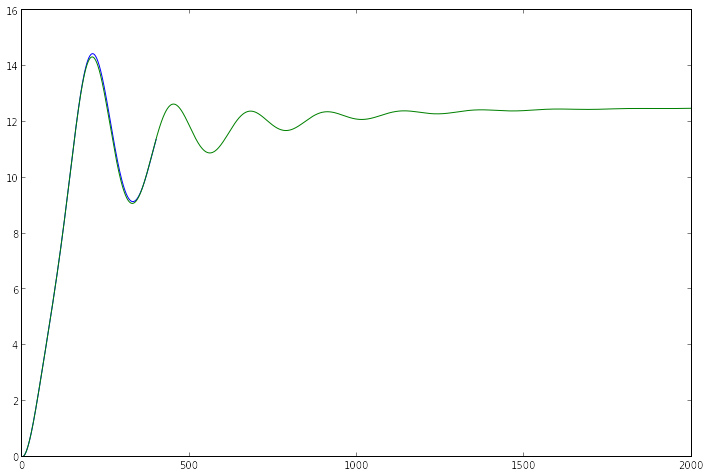

In [15]:
freq = 10.5054
mean_photons_down_check = mean_photons_calc(check_down[freq])
plt.plot(mean_photons_down_check)
mean_photons_down = mean_photons_calc(multi_results_down[freq])
plt.plot(mean_photons_down)

In [ ]:
#optimizing
initial_trial, difference = initial_parameters_calc(set1, set2)
theta = initial_trial[0, :]
xc = initial_trial[1, :]
yc = initial_trial[2, :]

initial_trial, difference = initial_parameters_calc(set1, set2)
initial_fidelities = fidelity_calc(set1, set2, initial_trial[:, :, np.newaxis])
theta_range = np.pi * np.ones([set1.shape[2]])
x_range = np.linalg.norm(difference, axis=0)
y_range = np.linalg.norm(difference, axis=0)
n_trials = 9
n_iterations = 5
refinement = 1.5

for idx in range(3):
    trials = new_trials(initial_trial, 0, theta_range, n_trials)
    initial_trial = best_guess(set1, set2, trials)
    trials = new_trials(initial_trial, 1, x_range, n_trials)
    initial_trial = best_guess(set1, set2, trials)
    trials = new_trials(initial_trial, 2, y_range, n_trials)
    initial_trial = best_guess(set1, set2, trials)
    theta_range = theta_range / refinement
    x_range = x_range / refinement
    y_range = y_range / refinement
    
best_trial = initial_trial
best_fidelities = fidelity_calc(set1, set2, best_trial[:, :, np.newaxis])

In [ ]:
best_fidelities, best_trials = optimize(set1, set2)

#plotting
time = 1850
size = 1
plt.scatter(set1[0, :, time], set1[1, :, time], color='k', s=size)
plt.scatter(set2[0, :, time], set2[1, :, time], color='r', s=size)
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
x_linspace = np.linspace(xlim[0], xlim[1])
y_points = divider(x_linspace[:, np.newaxis], best_trials[:, :, np.newaxis])
plt.plot(x_linspace, y_points[:, time, 0], color='g')
plt.xlim(xlim)
plt.ylim(ylim)
print best_fidelities[time, 0]


In [ ]:
set1_mean = np.mean(set1, axis=1)
set2_mean = np.mean(set2, axis=1)
plt.plot(set1_mean[0,:])
plt.plot(set2_mean[0,:])

In [ ]:
set1_mean = np.mean(set1, axis=1)
set2_mean = np.mean(set2, axis=1)
plt.plot(set1_mean[1,:])
plt.plot(set2_mean[1,:])

In [ ]:
key = 10.5066
I_u = I_dict_u[key]
I_int_u = np.cumsum(I_u, axis=1)
Q_u = Q_dict_u[key]
Q_int_u = np.cumsum(Q_u, axis=1)
I_d = I_dict_d[key]
I_int_d = np.cumsum(I_d, axis=1)
Q_d = Q_dict_d[key]
Q_int_d = np.cumsum(Q_d, axis=1)

lower = 1
upper = 2000

set1 = np.array([I_d[:,lower:upper], Q_d[:,lower:upper]])
set2 = np.array([I_u[:,lower:upper], Q_u[:,lower:upper]])

set1_int = np.array([I_int_d[:,lower:upper], Q_int_d[:,lower:upper]])
set2_int = np.array([I_int_u[:,lower:upper], Q_int_u[:,lower:upper]])

In [ ]:
type(I_dict_u.keys())

In [ ]:
#plotting
time = 1850
plt.scatter(set1[0, :, time], set1[1, :, time], color='k')
plt.scatter(set2[0, :, time], set2[1, :, time], color='r')
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
x_linspace = np.linspace(xlim[0], xlim[1])
initial_trial, difference = initial_parameters_calc(set1, set2)
y_points = divider(x_linspace[:, np.newaxis], initial_trial[:, :, np.newaxis])
plt.plot(x_linspace, y_points[:, time, 0])
plt.xlim(xlim)
plt.ylim(ylim)
print initial_fidelities[time, 0]

y_points = divider(x_linspace[:, np.newaxis], best_trial[:, :, np.newaxis])
plt.plot(x_linspace, y_points[:, time, 0], color='g')
plt.xlim(xlim)
plt.ylim(ylim)
print best_fidelities[time, 0]


In [ ]:
a = dict()
a['hello'] = np.ones(3)
np.save('test.npy', a)

In [ ]:
b = np.load('test.npy')

In [ ]:
b[()]['hello']